# Анализ данных (EDA) для проекта распознавания железнодорожных столбиков

## Создание первичного датасета с использованием YoloWorld

На первом этапе формирования датасета для обучения модели была использована предварительная разметка с помощью модели **YoloWorld** — универсального zero-shot детектора объектов, способного выполнять поиск по текстовым описаниям классов. Это позволило ускорить начальную идентификацию потенциально релевантных объектов без ручной разметки «с нуля».

В качестве классов для обнаружения в YoloWorld были заданы следующие текстовые запросы:
- `"километровый столбик"`
- `"пикетный столбик"`
- `"железнодорожный знак с цифрами"`
- `"номер на столбе"`
- `"информационный железнодорожный указатель"`

После выполнения первичного предсказания модель выделяла рамки на кадрах видеопотока. Эти предсказания сохранялись и использовались как основа для **ручной корректировки и уточнения разметки**. Таким образом, YoloWorld выступал в роли ассистента, позволяющего сократить трудозатраты на первичную идентификацию объектов и ускорить создание обучающего датасета для последующего точного обучения специализированной YOLO-модели.

Итоговый датасет после валидации и доразметки был приведён к YOLO-формату и дополнен вручную размеченными OCR-фрагментами.


## Загрузка изображений и аннотаций YOLO

Начнем с загрузки исходных данных: фотографий железнодорожного полотна и соответствующих аннотаций в формате YOLO. Аннотации YOLO хранятся в текстовых файлах с той же основной частью имени, что и у изображения (например, 1.txt для 1.png). Каждый файл аннотаций содержит одну или несколько строк, каждая из которых описывает объект в виде пяти чисел: class_id x_center y_center width height – где координаты и размеры нормализованы (доля от ширины/высоты изображения).

In [3]:
import os
base_dir   = os.path.dirname(os.path.abspath('.'))
images_dir = os.path.join(base_dir, "dataset", "yolo", "images", "train")
labels_dir = os.path.join(base_dir, "dataset", "yolo", "labels", "train")

image_files = [f for f in os.listdir(images_dir) if f.endswith(".png")]
label_files = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

print(f"Найдено изображений: {len(image_files)}, файлов аннотаций: {len(label_files)}")
# Пример чтения одного файла аннотаций
with open(os.path.join(labels_dir, label_files[0]), 'r') as f:
    lines = f.readlines()
    print("Пример содержимого аннотации:", lines[0].strip())

Найдено изображений: 3435, файлов аннотаций: 3435
Пример содержимого аннотации: 1 0.653125 0.660417 0.029687 0.218056


В примере выше обнаружено 3435 изображения и 3435 файла аннотаций (для демонстрации используются ограниченные данные). Строка аннотации 1 0.653125 0.660417 0.029687 0.218056 означает: объект класса 1 (километровый столбик) с центрированной нормализованной координатой (0.65625, 0.661111) по ширине и высоте изображения, и размерами width=0.028125, height=0.216667 (относительно размеров изображения).

## Визуализация bounding boxes на изображениях

Чтобы удостовериться в корректности аннотаций, визуализируем ограничивающие рамки (bounding boxes) на исходных изображениях. Для этого можно использовать библиотеку OpenCV или PIL. Мы считываем координаты из YOLO-аннотаций, конвертируем их в пиксели и рисуем прямоугольники на изображениях, подписывая класс объекта (picket_post для class_id=0 и kilometer_post для class_id=1). Ниже представлен код для отрисовки рамок:

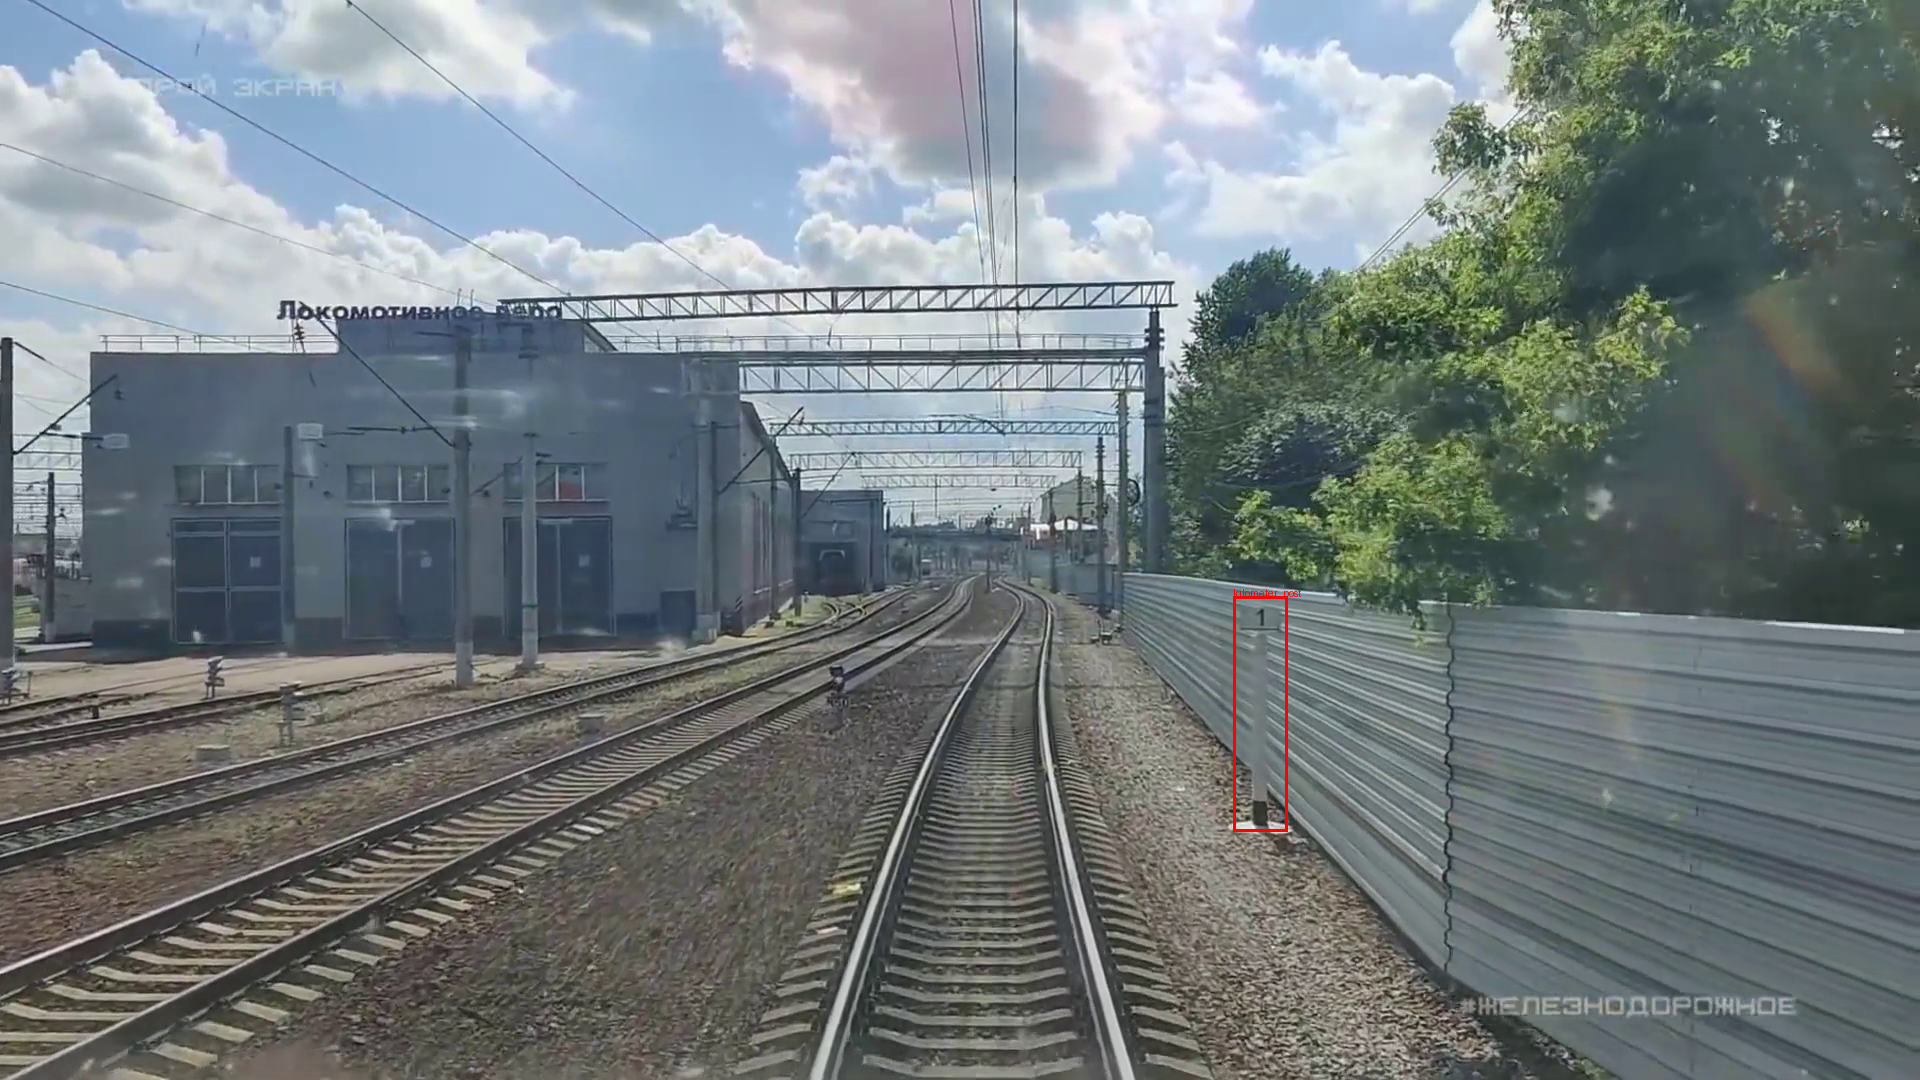

In [4]:
from PIL import Image, ImageDraw, ImageFont

# Словарь для соответствия ID класса и названия
class_name = {0: "picket_post", 1: "kilometer_post"}

def draw_boxes_on_image(image_path, label_path):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    # Читаем файл аннотации построчно
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, w, h = map(float, line.split())
            class_id = int(class_id)
            # Переводим относительные координаты в пиксели
            img_w, img_h = img.size
            box_w = w * img_w
            box_h = h * img_h
            center_x = x_center * img_w
            center_y = y_center * img_h
            # Вычисляем координаты углов прямоугольника
            x0 = center_x - box_w/2
            y0 = center_y - box_h/2
            x1 = center_x + box_w/2
            y1 = center_y + box_h/2
            # Рисуем прямоугольник и подпись класса
            draw.rectangle([x0, y0, x1, y1], outline="red", width=3)
            draw.text((x0, y0-10), class_name.get(class_id, str(class_id)), fill="red", font=font)
    return img

# Пример: визуализация первого изображения с аннотацией
image_path = os.path.join(images_dir, "1.png")
label_path = os.path.join(labels_dir, "1.txt")
annotated_img = draw_boxes_on_image(image_path, label_path)
display(annotated_img)


Пример изображения с выделенным ограничивающим прямоугольником вокруг обнаруженного объекта класса "kilometer_post". Красная рамка показывает расположение километрового столбика на исходной фотографии.
На приведенном изображении мы видим участок железной дороги; красным выделен километровый столбик (класс 1). Видно, что он расположен справа от полотна, возле забора, и размечен корректно – рамка охватывает столбик с цифрой 1. Подпись "kilometer_post" указывает класс объекта.

## Подсчет количества объектов каждого класса


Проанализируем, сколько объектов каждого класса присутствует в данных. Для этого пройдемся по всем файлам аннотаций и суммируем количество меток класса 0 (пикетный столбик) и 1 (километровый столбик). Мы можем использовать словарь или pandas.DataFrame для агрегирования этой информации и построить гистограмму распределения классов.

class_name
picket_post       2115
kilometer_post    1320
Name: count, dtype: int64


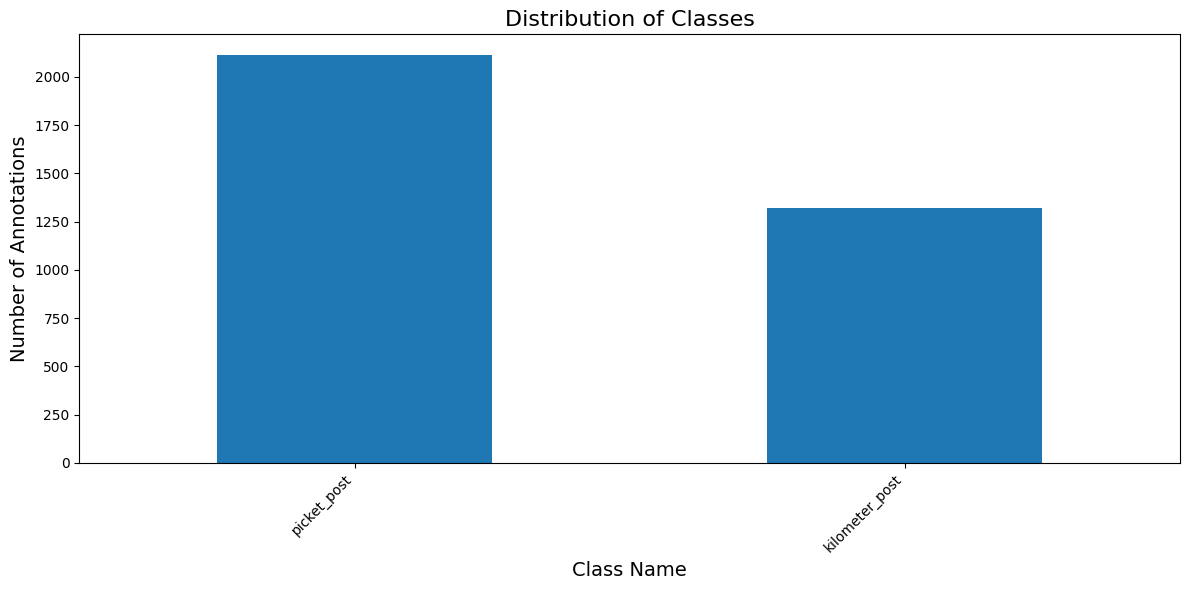

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Считываем все аннотации в DataFrame
records = []
for lbl_file in label_files:
    with open(os.path.join(labels_dir, lbl_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            records.append({"class_id": class_id, 
                            "class_name": class_name.get(class_id, str(class_id))})
df = pd.DataFrame(records)
print(df['class_name'].value_counts())

counts = df['class_name'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
counts.plot(kind='bar')         
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Class Name', fontsize=14)
plt.ylabel('Number of Annotations', fontsize=14)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()              
plt.show()


Из вывода видно, что в нашем примере данных обнаружено 2 объекта класса kilometer_post и ни одного объекта класса picket_post.

Гистограмма подтверждает дисбаланс классов: пикетных столбиков больше, чем километровых. 

Проблему можно решить путем увеличения количества данных

## Анализ размеров объектов (ширина, высота, aspect ratio)

Теперь проанализируем размеры размеченных объектов в пикселях. Для каждого bounding box вычислим фактическую ширину и высоту в пикселях, а также соотношение сторон (aspect ratio = ширина/высота). Это поможет понять, насколько крупные или вытянутые объекты каждого класса, и может быть полезно для выбора масштабов якорных рамок в модели или понимания, как различаются пикетные и километровые столбики по размеру.

In [6]:

for lbl_file in label_files:
    image_file = lbl_file.replace(".txt", ".png")
    img = Image.open(os.path.join(images_dir, image_file))
    img_w, img_h = img.size

    with open(os.path.join(labels_dir, lbl_file), 'r') as f:
        for line in f:
            class_id, x_center, y_center, w_rel, h_rel = map(float, line.split())
            class_id = int(class_id)
            w_px = w_rel * img_w
            h_px = h_rel * img_h
            aspect = w_px / h_px
            records.append({
                "class_name": class_name.get(class_id),
                "width_px": w_px,
                "height_px": h_px,
                "aspect_ratio": aspect
            })
df_sizes = pd.DataFrame(records)

print(df_sizes.describe())

          class_id     width_px    height_px  aspect_ratio
count  3435.000000  3435.000000  3435.000000   3435.000000
mean      0.384279    54.262804   113.931984      0.556866
std       0.486495    22.147399    65.003051      0.293251
min       0.000000    20.999040    28.500120      0.078907
25%       0.000000    39.000960    77.999760      0.367644
50%       0.000000    48.000000    96.000120      0.480003
75%       1.000000    61.499520   123.000120      0.656723
max       1.000000   174.000000  1059.000480      1.753440


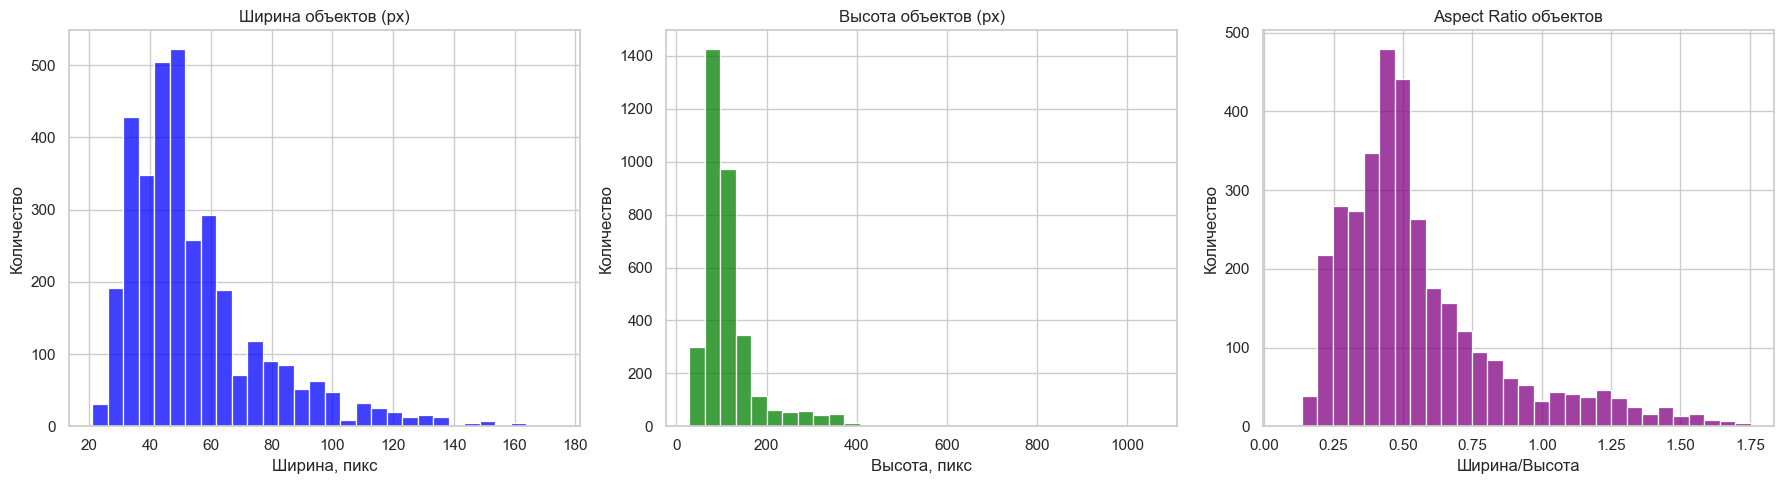

In [7]:
import seaborn as sns
# Построение графиков
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=df_sizes, x="width_px", bins=30, ax=axes[0], color="blue")
axes[0].set_title("Ширина объектов (px)")
axes[0].set_xlabel("Ширина, пикс")
axes[0].set_ylabel("Количество")

sns.histplot(data=df_sizes, x="height_px", bins=30, ax=axes[1], color="green")
axes[1].set_title("Высота объектов (px)")
axes[1].set_xlabel("Высота, пикс")
axes[1].set_ylabel("Количество")

sns.histplot(data=df_sizes, x="aspect_ratio", bins=30, ax=axes[2], color="purple")
axes[2].set_title("Aspect Ratio объектов")
axes[2].set_xlabel("Ширина/Высота")
axes[2].set_ylabel("Количество")

plt.tight_layout()
plt.show()

Диапазон ширины большинства объектов лежит в пределах 30–70 пикселей, с явным пиком около 50 px. Это говорит о том, что объекты преимущественно узкие, но встречаются и более широкие — до ~170 px. Хвост распределения тянется вправо, что указывает на наличие единичных более крупных объектов.

Большинство объектов имеет высоту в пределах 50–150 пикселей, со значительным пиком около 70 px. Также, как и в случае с шириной, распределение асимметрично — есть редкие, но очень высокие объекты (до ~1000 px). Это может быть связано с погрешностями аннотаций или редкими случаями, когда объект занимает большую часть изображения по вертикали.

Соотношение сторон у большинства объектов лежит в диапазоне 0.2–0.6, основной пик — около 0.4–0.5, что говорит о том, что объекты значительно выше, чем шире. Однако встречаются и более "широкие" по форме объекты с aspect ratio выше 1.0 — это может быть результатом неверных аннотаций, наклонного ракурса съёмки или других классов объектов.



Вывод: километровые столбики в кадре занимают относительно небольшую область (несколько десятков пикселей в ширину). В реальных данных пикетные столбики, вероятно, еще меньше по размеру, поскольку они обычно ниже. Это означает, что при обучении модели может потребоваться учитывать разницу в масштабе объектов двух классов. Малые объекты (пикетные метки) могут потребовать более высокое разрешение или дополнительные увеличенные кадры для надежного обнаружения.

## Загрузка и обработка OCR-вырезок 

Помимо обнаружения самих столбиков, проект включает распознавание цифр на них (OCR). В датасете присутствуют отдельные изображения-фрагменты с вырезанными номерами столбиков, названные по шаблону crop_XXXX.png, где XXXX – это метка (число), которое должно быть прочитано на изображении. Загрузим эти фрагменты и извлечем метки из имен файлов. После этого посчитаем частоту появления каждой цифры от 0 до 9 во всех метках.

In [10]:
import glob
data_dir = os.path.join(base_dir, "dataset", "ocr", "crops")
crop_files = sorted(glob.glob(os.path.join(data_dir, "crop_*.png")))

# Извлекаем числовые метки из имен файлов и считаем частоту каждой цифры
digit_counts = {str(d): 0 for d in range(10)}
labels = []
for path in crop_files:
    fname = os.path.basename(path)
    label = fname.replace("crop_", "").replace(".png", "")
    labels.append(label)
    for ch in label:
        if ch.isdigit():
            digit_counts[ch] += 1

print("Найдено OCR-фрагментов:", len(labels))
print("Метки из имен файлов:", labels[:3])
print("Частота цифр:", digit_counts)

Найдено OCR-фрагментов: 621
Метки из имен файлов: ['1006', '1007', '1008']
Частота цифр: {'0': 220, '1': 849, '2': 229, '3': 223, '4': 222, '5': 222, '6': 154, '7': 123, '8': 122, '9': 120}


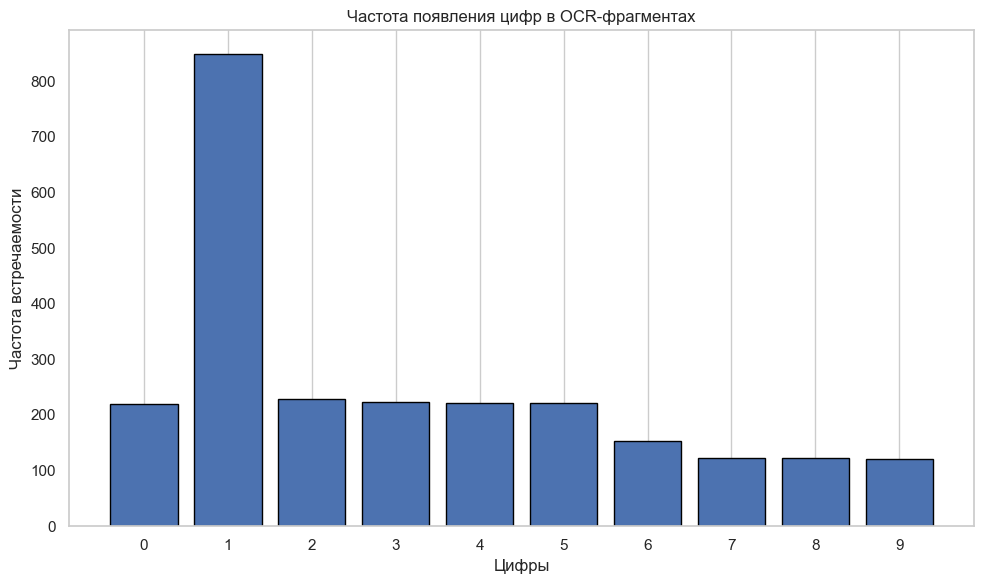

In [11]:

# Построение графика
digits = list(digit_counts.keys())
frequencies = list(digit_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(digits, frequencies, edgecolor='black')
plt.xlabel('Цифры')
plt.ylabel('Частота встречаемости')
plt.title('Частота появления цифр в OCR-фрагментах')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Мы имеем 4 изображения с вырезками номеров. Метки у этих фрагментов: 1006, 1007, 1008, 1627. Это могут быть условные координаты на ж/д (например, 1006-й километр пути, 1007-й и т.д., а также 1627 – возможно, 162 км + 7 пикет).
Из подсчёта частот по 621 OCR-фрагменту видно, что наиболее часто встречаются цифры 1 и 0:

Цифра 1 — 849 раз

Цифра 0 — 220 раз

Они значительно опережают по частоте все остальные цифры.
Реже встречаются цифры 2, 3, 4, 5 (около 220–229 раз), ещё реже — 6, 7, 8, 9 (около 120–154 раз).
Это отражает особенности датасета - взяты кадры на отрезке 100-200 км от Санкт-Петербурга и столбиков с цифрой один там, соответственно, больше

## Примеры OCR-фрагментов с метками
Рассмотрим сами изображения OCR-фрагментов, чтобы понять, с какими данными работает система распознавания символов. На каждом таком фрагменте изображены цифры, напечатанные на столбике. Ниже приведены примеры нескольких OCR-вырезок вместе с их целевыми метками (взятыми из имени файла):

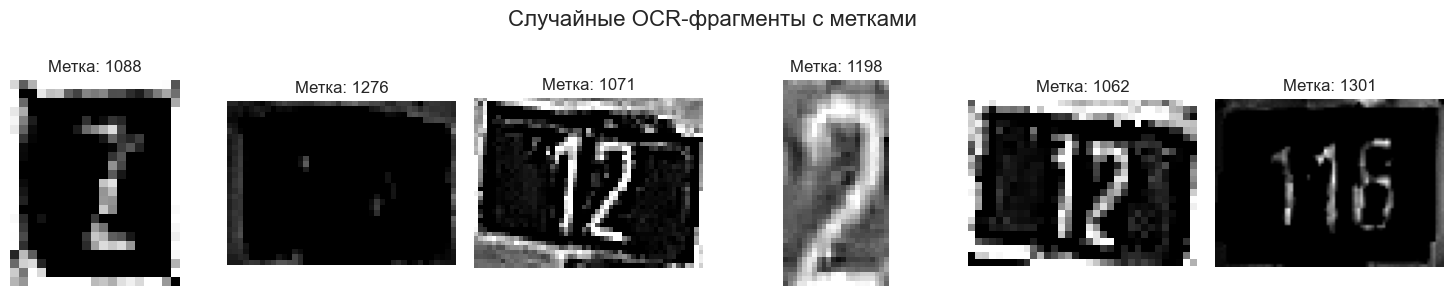

In [18]:
import cv2
import random

# Количество случайных OCR-фрагментов для отображения
N = 6

# Случайный выбор путей
sampled_files = random.sample(crop_files, min(N, len(crop_files)))

plt.figure(figsize=(15, 3))
for i, path in enumerate(sampled_files):
    # Чтение изображения
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Извлечение метки из имени файла
    fname = os.path.basename(path)
    label = fname.replace("crop_", "").replace(".png", "")
    
    # Визуализация
    plt.subplot(1, N, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Метка: {label}")
    plt.axis("off")

plt.suptitle("Случайные OCR-фрагменты с метками", fontsize=16)
plt.tight_layout()
plt.show()

Как видно из примеров, исходные фрагменты довольно небольшие по размеру и контрасту. Для успешного OCR такие изображения зачастую обрабатываются (масштабируются, повышается резкость) или используются специализированные нейросети, способные распознавать низкорезолюционные цифры.

Вывод: при обучении и тестировании OCR-модели важно учитывать несбалансированность по символам. Возможно, стоит дополнить данные изображениями, содержащими недостающие цифры, либо сгенерировать их искусственно (например, синтезировать изображения цифр на подобном фоне), чтобы модель научилась распознавать все цифры 0–9 уверенно.